# ДЗ 3
## Екатерина Кострыкина

In [ ]:
!wget https://www.dropbox.com/s/tn6x5f4ybaj34zf/Fake.csv?dl=0 -O data.csv

--2021-12-15 17:37:52--  https://www.dropbox.com/s/tn6x5f4ybaj34zf/Fake.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tn6x5f4ybaj34zf/Fake.csv [following]
--2021-12-15 17:37:53--  https://www.dropbox.com/s/raw/tn6x5f4ybaj34zf/Fake.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7105e6180157817542c866d4b1.dl.dropboxusercontent.com/cd/0/inline/Bb6H_jGDhplu3pyyr9F72u46zFqkesUfMyvYBlvzuiNMY6TRYoXGqElAHEDXOZ8z2ome9CTg8-89ck35TjrbgvEdx0TPfW4TKEXl2x5W7pj-LoAHf3VBKHJWExCWQyEoNeDfWHDowHCAkxBJ6Lfc5dqb/file# [following]
--2021-12-15 17:37:53--  https://uc7105e6180157817542c866d4b1.dl.dropboxusercontent.com/cd/0/inline/Bb6H_jGDhplu3pyyr9F72u46zFqkesUfMyvYBlvzuiNMY6TRYoXGqElAHEDXOZ8z2ome9CTg8-89ck35TjrbgvEdx0TPfW

In [ ]:
!pip install torchmetrics

     |████████████████████████████████| 332 kB 4.4 MB/s 


In [ ]:
!pip install ipdb

     |████████████████████████████████| 791 kB 4.2 MB/s 
     |████████████████████████████████| 374 kB 39.8 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=0476ea6a77880df8ea47be253c7061d7d0fdc0812d8f3debf58889c262ada738
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 

In [ ]:
import re
import pandas as pd
import numpy as np


import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from string import punctuation
punctuation += '...' + '—' + '…' + '«»'

from collections import Counter
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall, accuracy

import ipdb

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df = pd.read_csv('/content/data.csv')

In [ ]:
df

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


мб статистика

Preprocessing 

In [ ]:
def preprocess(text): 
    text = text.lower()
    text = [i for i in word_tokenize(text) if i not in punctuation]
    return ' '.join(text)

In [ ]:
df['preprocessed'] = df['text'].apply(preprocess)

In [ ]:
df.head()

,title,text,subject,date,preprocessed
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",donald trump just couldn t wish all americans ...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",house intelligence committee chairman devin nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",on friday it was revealed that former milwauke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",on christmas day donald trump announced that h...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",pope francis used his annual christmas day mes...


In [ ]:
df['subject'].unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [ ]:
df['label'] = df['subject'].map({'News': 0, 'politics':1, 
                                 'Government News': 2, 'left-news':3, 
                                 'US_News':4, 'Middle-east':5
                                 })

In [ ]:
df['label'].unique()

array([0, 1, 2, 3, 4, 5])

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
vocab = Counter()

for text in df['preprocessed']:
    vocab.update(text.split())
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 181352


In [ ]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 5 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 5 раз: 36522


In [ ]:
word2id = {'UNK':0} # в статье сказали unknown words заменть токеном

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

В статье сказано брать MAX_LEN равный максимальной длине текста в датасете, но у нас она слишком большая получается и не влезает в память колаба

In [ ]:
train['preprocessed'].str.split().apply(len)

21326    225
15981    271
18573    306
316      500
11217    519
        ... 
11964    263
21575    467
5390     329
860      870
15795    249
Name: preprocessed, Length: 18784, dtype: int64

Поэтому посмотрим среднюю длину по текстам

In [ ]:
(train['preprocessed'].str.split().apply(len)).mean()

425.13756388415675

допустим возьмем 450 в качестве MAX_LEN

In [ ]:
MAX_LEN = 450

In [ ]:
class MyDataset(Dataset):
    def __init__(self, dataset, col, target_col, word2id, max_len, DEVICE):
        self.dataset = dataset[col].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset[target_col].values)
        self.max_len = max_len
        self.device = DEVICE
    
    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index].split()
        ids = torch.LongTensor([self.word2id[token] if token in self.word2id else self.word2id['UNK'] for token in tokens][:self.max_len])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = torch.vstack([F.pad(seq, pad=(0, self.max_len - seq.shape[0]), mode='constant', value=0) for seq in ids])
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.LongTensor(y).to(self.device)
      return padded_ids, y.T[0]

In [ ]:
train_dataset = MyDataset(train, 'preprocessed', 'label', word2id, MAX_LEN, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=128)

In [ ]:
val_dataset = MyDataset(test, 'preprocessed', 'label', word2id, MAX_LEN, DEVICE)
val_sampler = RandomSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=128)

Word2Vec

In [ ]:
! wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-12-15 17:40:40--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.197.232
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.197.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  16.3MB/s    in 1m 44s  

2021-12-15 17:42:25 (15.1 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
import gensim

w2v_model = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)

In [ ]:
weights = np.zeros((len(word2id), 300))
for word, i in word2id.items():
    try:
        weights[i] = w2v_model[word]    
    except KeyError:
        weights[i] = torch.FloatTensor((300,)).uniform_(-0.25, 0.25)

In [ ]:
def train(train_dataloader, val_dataloader, model, optimizer, criterion, 
          NUM_EPOCHS, metric, device=DEVICE):
    
    model.to(device)

    losses = []
    val_losses = []
    metrics = []
    val_metrics = []
    epoch_val_metrics = []

    for epoch in range(NUM_EPOCHS):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, NUM_EPOCHS))

        model.train()  
        print('\nTraining...')

    # ========================================
    #               Training
    # ========================================

        epoch_loss = [] 
        epoch_metric = []

        for i, (*x, y) in enumerate(train_dataloader, 1):
            optimizer.zero_grad()
            preds = model(*x)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            batch_metric = metric(preds.argmax(1).long(), y.long(), average='weighted', num_classes=6, ignore_index=0)
            epoch_metric.append(batch_metric.cpu().numpy())
        losses.extend(epoch_loss)
        metrics.extend(epoch_metric)

        print('Train loss: ', np.mean(epoch_loss))
        print('Train metric: ', np.mean(epoch_metric))

        val_loss, val_metric = evaluate(val_dataloader, model, criterion, metric, device)
        val_losses.extend(val_loss)
        val_metrics.extend(val_metric)
        epoch_val_metrics.append(np.mean(val_metric))

    return losses, metrics, val_losses, val_metrics, epoch_val_metrics


def evaluate(dataloader, model, criterion, metric, device=DEVICE):
    
    print('\n~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~')
    print('\nValidation...')
    # ========================================
    #               Validation
    # ========================================
    epoch_loss = []
    epoch_metric = []
    model.eval() 

    with torch.no_grad():
        for i, (*x, y) in enumerate(dataloader):
            preds = model(*x)
            loss = criterion(preds, y)
            epoch_loss.append(loss.item())
            batch_metric = metric(preds.argmax(1).long(), y.long(), average='weighted', num_classes=6, ignore_index=0)
            epoch_metric.append(batch_metric.cpu().numpy())
    
    print('Val loss: ', np.mean(epoch_loss))
    print('Val metric: ', np.mean(epoch_metric))
        
    return epoch_loss, epoch_metric

In [ ]:
class CLSTM_model(nn.Module):
  def __init__(self, max_length, vocab_size, filter_sizes, drop_first):
    super().__init__()
    self.max_length = max_length
    self.vocab_size = vocab_size
    self.filter_sizes = filter_sizes
    self.drop_first = drop_first
    self.embedding = nn.Embedding(vocab_size, 300)
    self.embedding.from_pretrained(torch.tensor(weights))        
    self.conv2 = nn.Conv1d(in_channels=300, out_channels=150, kernel_size=2)
    self.conv3 = nn.Conv1d(in_channels=300, out_channels=150, kernel_size=3)
    self.conv4 = nn.Conv1d(in_channels=300, out_channels=150, kernel_size=4)
    self.conv = {2 : self.conv2, 
                 3 : self.conv3, 
                 4 : self.conv4}
    self.lstm = nn.LSTM(input_size=150, hidden_size=150, num_layers=1, batch_first=True)
    self.dropout = nn.Dropout(p=0.5)            
    self.relu = nn.ReLU()
    self.out = nn.Softmax(dim=1)
    self.linear = nn.Linear(150, 6) # 6 выходов

  def forward(self, text):
    embedded = self.dropout(self.embedding(text))
    embedded = embedded.transpose(1, 2)
    max_len = self.max_length - max(self.filter_sizes) + 1
    outputs = []
    for filter_size in self.filter_sizes:
      layer = self.conv[filter_size]
      layer = layer(embedded)
      hidden = self.relu(layer)
      hidden = hidden[:, :, :max_len]
      outputs.append(h)
    if len(self.filter_sizes) > 1:
      rnn_inputs = torch.cat(outputs, -1)
    else:
      rnn_inputs = hidden 
    _, (hidden_state, _) = self.lstm(rnn_inputs.transpose(1, 2))
    if self.drop_first:
      embedded = self.dropout(embedded)
    logits = self.out(self.linear(torch.squeeze(hidden_state, 0)))
        
    return logits 

In [ ]:
model = CLSTM_model(max_length=MAX_LEN, vocab_size=len(word2id), filter_sizes=[2], drop_first=0)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

losses, metrics, val_losses, val_metrics, epoch_val_metrics = train(train_iterator, val_iterator, model, optimizer, criterion, NUM_EPOCHS=10, metric=accuracy)


======== Epoch 1 / 10 ========

Training...
Train loss:  1.5113202211808185
Train metric:  0.2721139

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.448882202844362
Val metric:  0.3495368

======== Epoch 2 / 10 ========

Training...
Train loss:  1.4430560944031696
Train metric:  0.3719199

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.444730449367214
Val metric:  0.35093507

======== Epoch 3 / 10 ========

Training...
Train loss:  1.4291682210909267
Train metric:  0.39957505

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.434846439877072
Val metric:  0.38298294

======== Epoch 4 / 10 ========

Training...
Train loss:  1.4190321114598488
Train metric:  0.4097902

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4273412775348973
Val metric:  0.38698184

======== Epoch 5 / 10 ========

Training...
Train loss:  1.4091721789366534
Train metric:  0.42452237

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4277511255161182
Val me

In [ ]:
import matplotlib.pyplot as plt

def show_results(train_loss, train_f1, val_loss, val_f1):
  plt.figure(figsize=(8, 6))
  plt.plot(train_loss)
  plt.plot(train_f1)
  plt.title('TRAIN')
  plt.ylabel('score')
  plt.xlabel('iterations')
  plt.grid()
  plt.legend(['loss', 'accuracy'], loc='upper right')
  plt.show()
  
  plt.figure(figsize=(8, 6))
  plt.plot(val_loss)
  plt.plot(val_f1)
  plt.title('TEST')
  plt.ylabel('score')
  plt.xlabel('iterations')
  plt.grid()
  plt.legend(['loss', 'accuracy'], loc='upper right')
  plt.show()

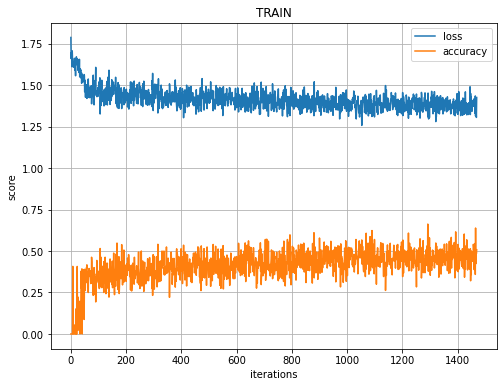

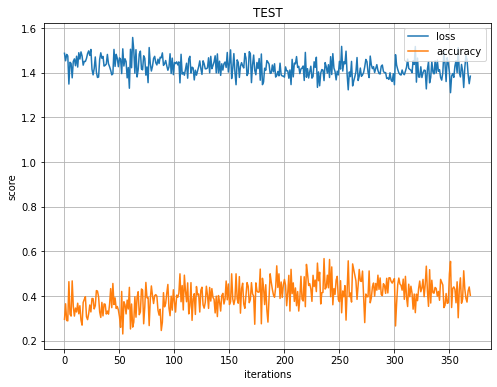

In [ ]:
show_results(losses, metrics, val_losses, val_metrics)

По графикам видно, что модель обучается. Медленно, но верно, лосс падает, accuracy растет

Попробуем подобрать гиперпараметры

PARAMETERS: 
drop_first=0, filters=[2]

======== Epoch 1 / 10 ========

Training...
Train loss:  1.5137814883472158
Train metric:  0.2755723

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4502747896555308
Val metric:  0.34754235

======== Epoch 2 / 10 ========

Training...
Train loss:  1.4456538797235814
Train metric:  0.3653022

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4491423658422522
Val metric:  0.37502196

======== Epoch 3 / 10 ========

Training...
Train loss:  1.4314594536411518
Train metric:  0.39536124

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4363945110424146
Val metric:  0.3633364

======== Epoch 4 / 10 ========

Training...
Train loss:  1.417318243558715
Train metric:  0.4196256

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4416079488960472
Val metric:  0.34866077

======== Epoch 5 / 10 ========

Training...
Train loss:  1.4102524681156183
Train metric:  0.4273514

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation

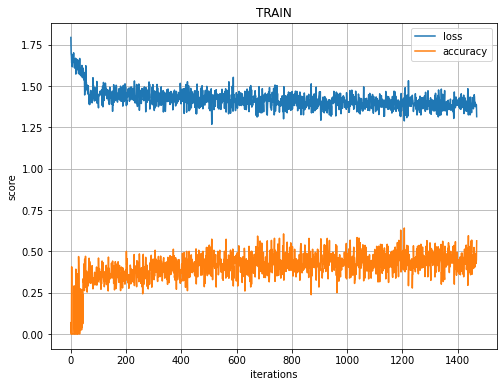

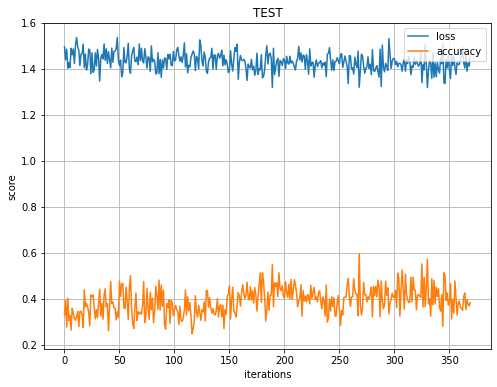

PARAMETERS: 
drop_first=0, filters=[3]

======== Epoch 1 / 10 ========

Training...
Train loss:  1.519623048451482
Train metric:  0.28226805

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4500598681939614
Val metric:  0.34851742

======== Epoch 2 / 10 ========

Training...
Train loss:  1.4406570196151733
Train metric:  0.3820684

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.447747243417276
Val metric:  0.40601355

======== Epoch 3 / 10 ========

Training...
Train loss:  1.4235455851976564
Train metric:  0.40850207

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.447101969976683
Val metric:  0.42838603

======== Epoch 4 / 10 ========

Training...
Train loss:  1.4145417870307455
Train metric:  0.41705889

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.432378752811535
Val metric:  0.37864748

======== Epoch 5 / 10 ========

Training...
Train loss:  1.406812113158557
Train metric:  0.42424858

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation

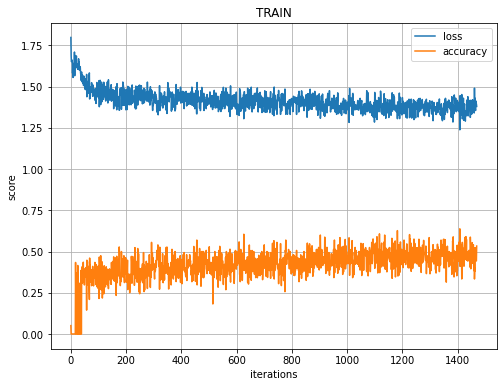

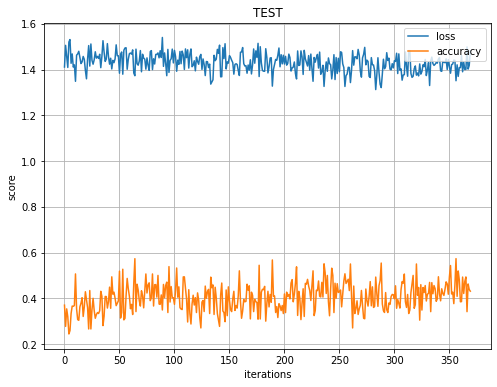

PARAMETERS: 
drop_first=0, filters=[4]

======== Epoch 1 / 10 ========

Training...
Train loss:  1.5332703087605586
Train metric:  0.28967303

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4511690784145046
Val metric:  0.34929338

======== Epoch 2 / 10 ========

Training...
Train loss:  1.4428851271973175
Train metric:  0.3776647

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.450233575460073
Val metric:  0.38626525

======== Epoch 3 / 10 ========

Training...
Train loss:  1.4230908285192891
Train metric:  0.40542218

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.438805019533312
Val metric:  0.39732513

======== Epoch 4 / 10 ========

Training...
Train loss:  1.4074713316093497
Train metric:  0.42619488

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.438062455203082
Val metric:  0.4199989

======== Epoch 5 / 10 ========

Training...
Train loss:  1.3907547532295694
Train metric:  0.45345378

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validatio

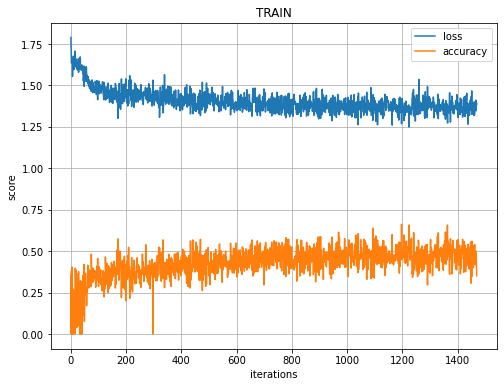

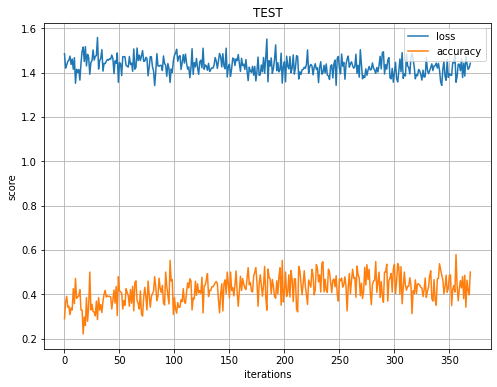

PARAMETERS: 
drop_first=0, filters=[2, 3]

======== Epoch 1 / 10 ========

Training...
Train loss:  1.5426825698541136
Train metric:  0.2513797

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4574775438050966
Val metric:  0.3512395

======== Epoch 2 / 10 ========

Training...
Train loss:  1.4450776431025292
Train metric:  0.37129733

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.445709457268586
Val metric:  0.3499783

======== Epoch 3 / 10 ========

Training...
Train loss:  1.4254923831848871
Train metric:  0.4041483

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4320585888785284
Val metric:  0.3933316

======== Epoch 4 / 10 ========

Training...
Train loss:  1.412267303791176
Train metric:  0.42338336

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4298927719528611
Val metric:  0.38213387

======== Epoch 5 / 10 ========

Training...
Train loss:  1.4003323924784759
Train metric:  0.4345023

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validatio

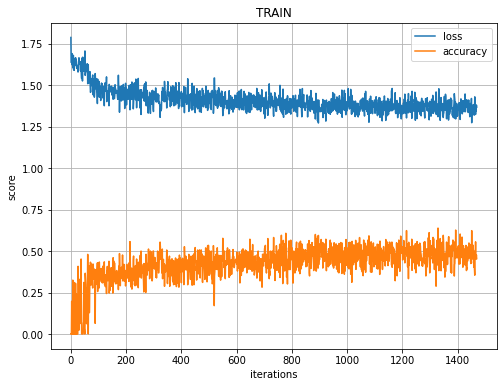

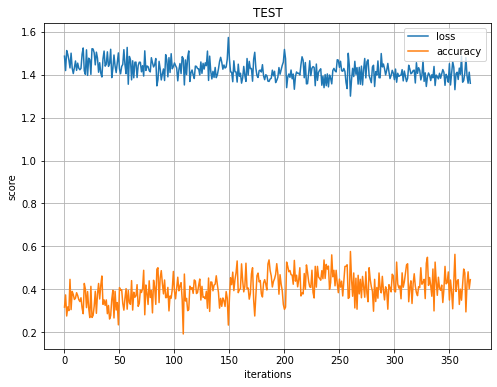

PARAMETERS: 
drop_first=0, filters=[2, 4]

======== Epoch 1 / 10 ========

Training...
Train loss:  1.5263763787795086
Train metric:  0.2679751

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4610675637786452
Val metric:  0.35602483

======== Epoch 2 / 10 ========

Training...
Train loss:  1.4391147620012972
Train metric:  0.389437

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4438152055482607
Val metric:  0.41021088

======== Epoch 3 / 10 ========

Training...
Train loss:  1.418624143211209
Train metric:  0.41472977

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.435102594865335
Val metric:  0.39351797

======== Epoch 4 / 10 ========

Training...
Train loss:  1.4062536030399555
Train metric:  0.4306855

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.425400128235688
Val metric:  0.38693556

======== Epoch 5 / 10 ========

Training...
Train loss:  1.3941198263038583
Train metric:  0.4434135

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validatio

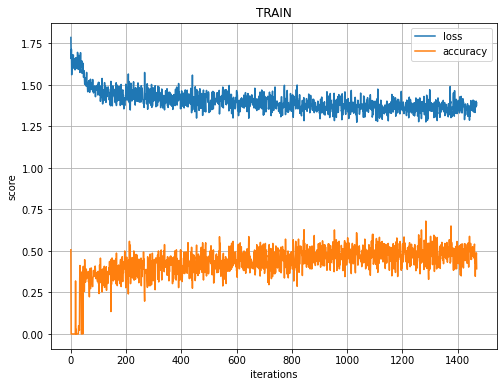

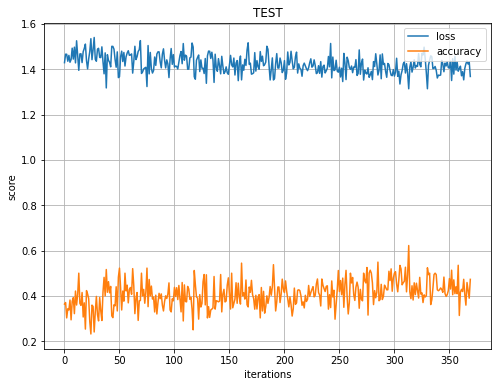

PARAMETERS: 
drop_first=0, filters=[3, 4]

======== Epoch 1 / 10 ========

Training...
Train loss:  1.5068843964816763
Train metric:  0.2966008

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4534984665947992
Val metric:  0.3458993

======== Epoch 2 / 10 ========

Training...
Train loss:  1.4393594767771611
Train metric:  0.38320354

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.436443264419968
Val metric:  0.40043777

======== Epoch 3 / 10 ========

Training...
Train loss:  1.4150327784674508
Train metric:  0.4197467

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.430892573820578
Val metric:  0.37341687

======== Epoch 4 / 10 ========

Training...
Train loss:  1.402626589041989
Train metric:  0.43706268

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4253987396085583
Val metric:  0.3872733

======== Epoch 5 / 10 ========

Training...
Train loss:  1.3895995251986446
Train metric:  0.452183

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation

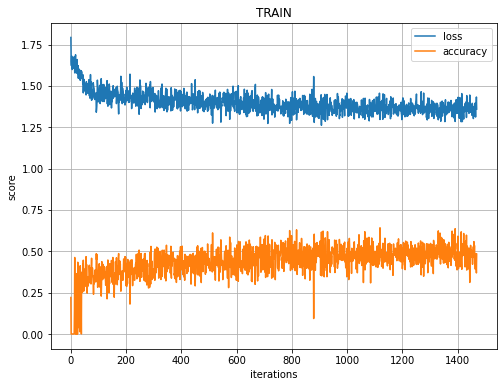

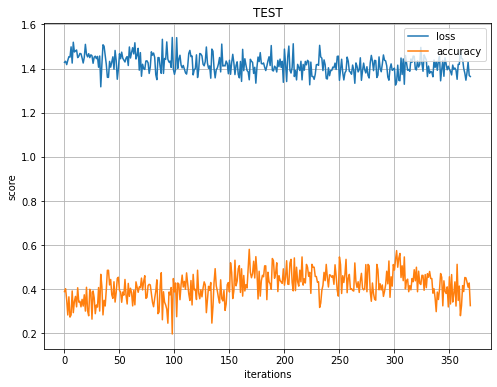

PARAMETERS: 
drop_first=0, filters=[2, 3, 4]

======== Epoch 1 / 10 ========

Training...
Train loss:  1.5203537470629427
Train metric:  0.29054558

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4521686805261147
Val metric:  0.3483688

======== Epoch 2 / 10 ========

Training...
Train loss:  1.4467242526359299
Train metric:  0.37464765

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4476034770140778
Val metric:  0.36472636

======== Epoch 3 / 10 ========

Training...
Train loss:  1.426390510838048
Train metric:  0.4044599

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4402111639847626
Val metric:  0.38428903

======== Epoch 4 / 10 ========

Training...
Train loss:  1.4103369501983227
Train metric:  0.42342433

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4312578020869076
Val metric:  0.38589522

======== Epoch 5 / 10 ========

Training...
Train loss:  1.4000949867728616
Train metric:  0.4355095

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Va

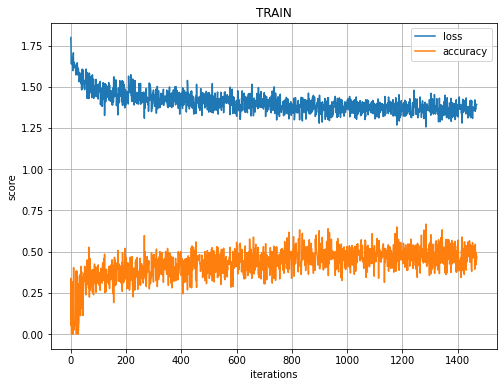

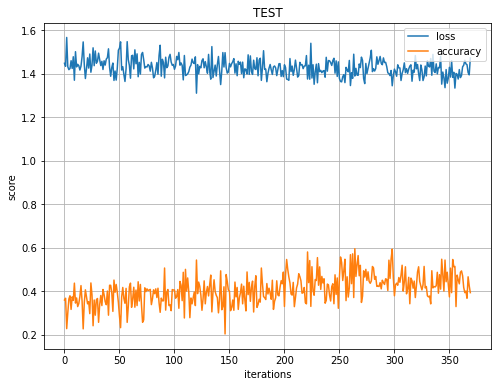

PARAMETERS: 
drop_first=1, filters=[2]

======== Epoch 1 / 10 ========

Training...
Train loss:  1.5985335354902306
Train metric:  0.14794095

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.5389426882202561
Val metric:  0.236513

======== Epoch 2 / 10 ========

Training...
Train loss:  1.5370493948865098
Train metric:  0.24375065

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.536159415502806
Val metric:  0.27746445

======== Epoch 3 / 10 ========

Training...
Train loss:  1.5308147944560668
Train metric:  0.24647476

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.5238547035165735
Val metric:  0.24063724

======== Epoch 4 / 10 ========

Training...
Train loss:  1.530380563671086
Train metric:  0.24302419

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.5222527175336271
Val metric:  0.25129893

======== Epoch 5 / 10 ========

Training...
Train loss:  1.5276744268378433
Train metric:  0.2516131

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validatio

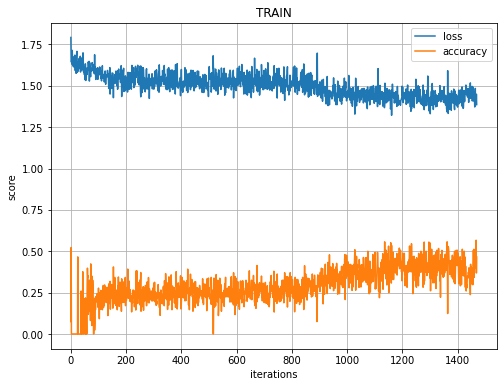

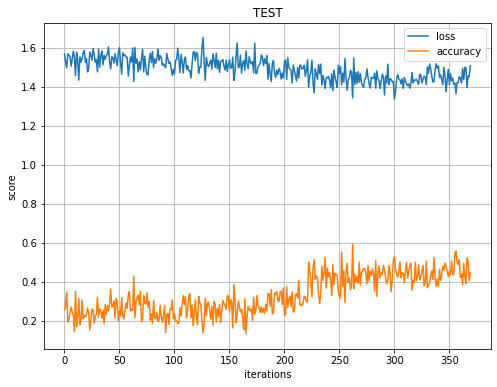

PARAMETERS: 
drop_first=1, filters=[3]

======== Epoch 1 / 10 ========

Training...
Train loss:  1.522457941859758
Train metric:  0.26376173

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4505701097282204
Val metric:  0.3470951

======== Epoch 2 / 10 ========

Training...
Train loss:  1.4506821908107421
Train metric:  0.35588032

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4444153824368038
Val metric:  0.34872293

======== Epoch 3 / 10 ========

Training...
Train loss:  1.4414924553462438
Train metric:  0.37852228

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4373531760396183
Val metric:  0.4002454

======== Epoch 4 / 10 ========

Training...
Train loss:  1.433213937039278
Train metric:  0.39325082

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4332107821026363
Val metric:  0.42959026

======== Epoch 5 / 10 ========

Training...
Train loss:  1.4246057523351137
Train metric:  0.40968776

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validati

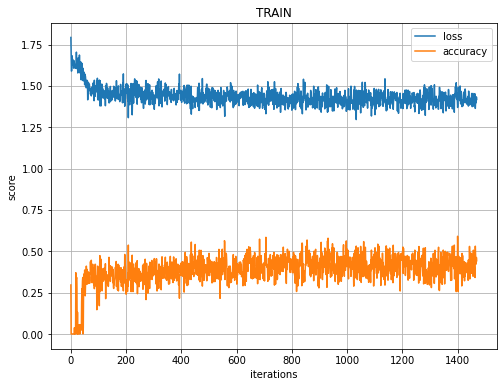

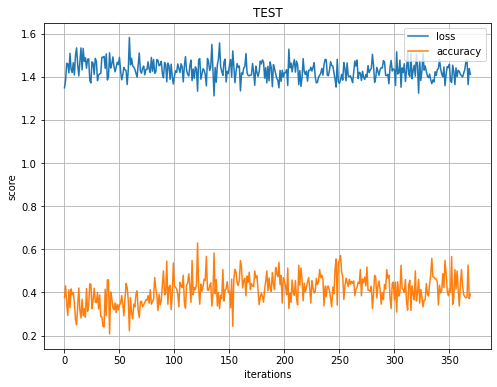

PARAMETERS: 
drop_first=1, filters=[4]

======== Epoch 1 / 10 ========

Training...
Train loss:  1.5514849837945432
Train metric:  0.21790208

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4515615057300877
Val metric:  0.34632152

======== Epoch 2 / 10 ========

Training...
Train loss:  1.4524108163353537
Train metric:  0.35092545

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4473397635124825
Val metric:  0.3488377

======== Epoch 3 / 10 ========

Training...
Train loss:  1.4446211664044126
Train metric:  0.37121633

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4384023112219733
Val metric:  0.3716859

======== Epoch 4 / 10 ========

Training...
Train loss:  1.433865715046318
Train metric:  0.39219323

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4311649573815834
Val metric:  0.38253126

======== Epoch 5 / 10 ========

Training...
Train loss:  1.427061456401332
Train metric:  0.4048639

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validatio

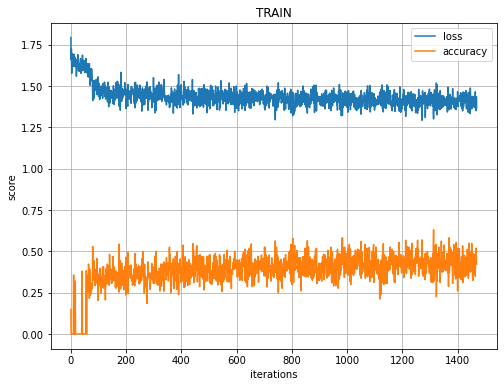

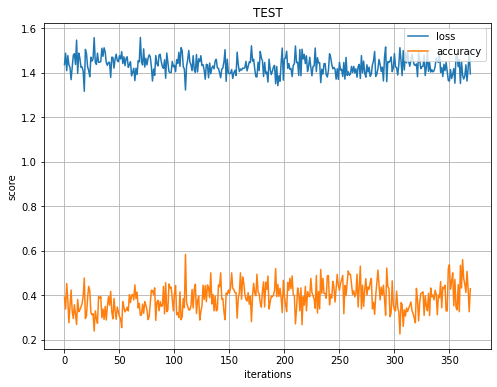

PARAMETERS: 
drop_first=1, filters=[2, 3]

======== Epoch 1 / 10 ========

Training...
Train loss:  1.5624731106012046
Train metric:  0.20485532

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4541453058655198
Val metric:  0.3440867

======== Epoch 2 / 10 ========

Training...
Train loss:  1.4504744690291735
Train metric:  0.35738564

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4426430689321983
Val metric:  0.34829965

======== Epoch 3 / 10 ========

Training...
Train loss:  1.4401075329099382
Train metric:  0.38121173

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4306358646702122
Val metric:  0.39771548

======== Epoch 4 / 10 ========

Training...
Train loss:  1.4289311689584434
Train metric:  0.40620044

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4229389429092407
Val metric:  0.415798

======== Epoch 5 / 10 ========

Training...
Train loss:  1.4210486274187257
Train metric:  0.42073444

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Vali

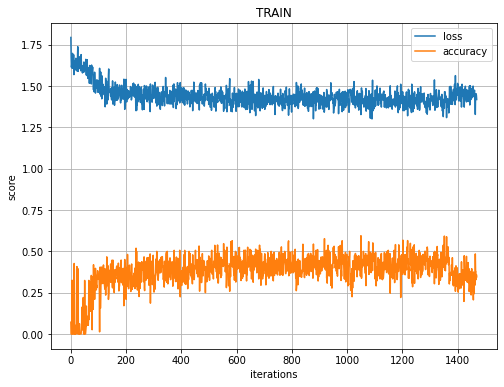

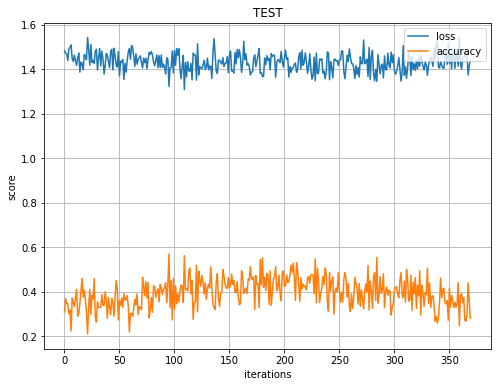

PARAMETERS: 
drop_first=1, filters=[2, 4]

======== Epoch 1 / 10 ========

Training...
Train loss:  1.5805443030636326
Train metric:  0.1779396

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4930761988098558
Val metric:  0.35034066

======== Epoch 2 / 10 ========

Training...
Train loss:  1.4537766839371247
Train metric:  0.35741922

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4479507852245022
Val metric:  0.35799706

======== Epoch 3 / 10 ========

Training...
Train loss:  1.4418501034885847
Train metric:  0.3808671

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4431419275902413
Val metric:  0.38473594

======== Epoch 4 / 10 ========

Training...
Train loss:  1.4353947825983269
Train metric:  0.3937442

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4338915734677702
Val metric:  0.3628398

======== Epoch 5 / 10 ========

Training...
Train loss:  1.4265476343583088
Train metric:  0.40551075

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Valid

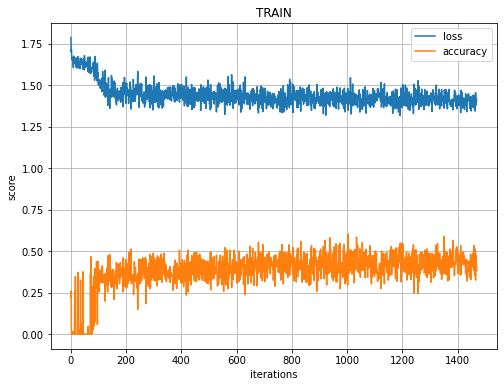

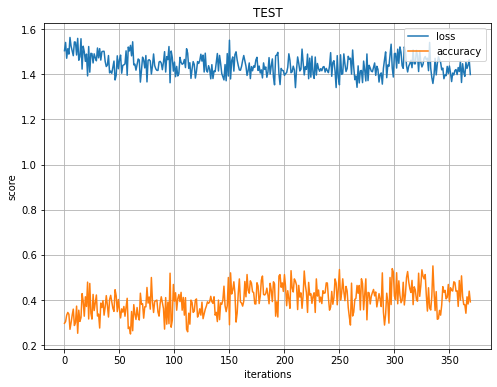

PARAMETERS: 
drop_first=1, filters=[3, 4]

======== Epoch 1 / 10 ========

Training...
Train loss:  1.568335882660483
Train metric:  0.20874636

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4548104614824862
Val metric:  0.34773117

======== Epoch 2 / 10 ========

Training...
Train loss:  1.453488936229628
Train metric:  0.35321093

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4481607707771096
Val metric:  0.34951466

======== Epoch 3 / 10 ========

Training...
Train loss:  1.4450543105196791
Train metric:  0.3679109

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.447398710895229
Val metric:  0.34720737

======== Epoch 4 / 10 ========

Training...
Train loss:  1.4403774843734949
Train metric:  0.3853452

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4322651656898293
Val metric:  0.40336224

======== Epoch 5 / 10 ========

Training...
Train loss:  1.4333974617679104
Train metric:  0.39341792

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Valida

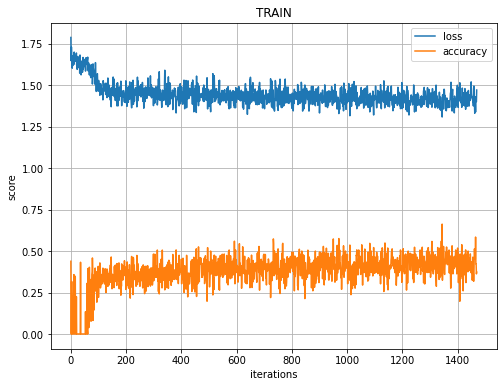

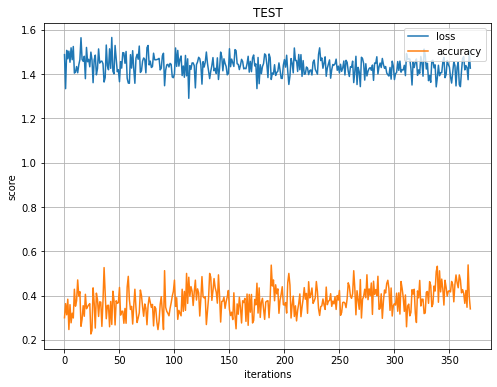

PARAMETERS: 
drop_first=1, filters=[2, 3, 4]

======== Epoch 1 / 10 ========

Training...
Train loss:  1.5514940947902447
Train metric:  0.26629192

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.486335786613258
Val metric:  0.3480446

======== Epoch 2 / 10 ========

Training...
Train loss:  1.454268091389922
Train metric:  0.35365766

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4481785845112156
Val metric:  0.346613

======== Epoch 3 / 10 ========

Training...
Train loss:  1.4436069751272396
Train metric:  0.37573293

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.446797032614012
Val metric:  0.34481078

======== Epoch 4 / 10 ========

Training...
Train loss:  1.4320919310965505
Train metric:  0.40116447

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Validation...
Val loss:  1.4669742809759605
Val metric:  0.44696447

======== Epoch 5 / 10 ========

Training...
Train loss:  1.4246877415650556
Train metric:  0.4121144

~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~

Valid

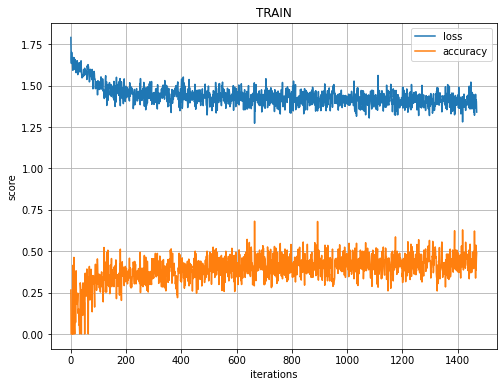

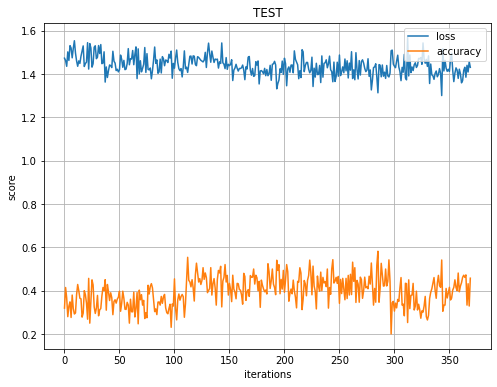

In [54]:
best_params = {}
best_accuracy = 0
filters_gc = [[2], [3], [4], [2, 3], [2, 4], [3, 4], [2, 3, 4]]

for drop_first in [0, 1]:
  for filters in filters_gc:
    print('PARAMETERS: ')
    print(f'drop_first={drop_first}, filters={filters}')
    model = CLSTM_model(max_length=MAX_LEN, 
                        vocab_size=len(word2id), 
                        filter_sizes=filters, 
                        drop_first=drop_first)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
    criterion = nn.CrossEntropyLoss()
    losses, metrics, val_losses, val_metrics, epoch_val_metrics = train(train_iterator, 
                                                                        val_iterator, 
                                                                        model, optimizer, 
                                                                        criterion, 
                                                                        NUM_EPOCHS=10, 
                                                                        metric=accuracy)    
    show_results(losses, metrics, val_losses, val_metrics)
    if epoch_val_metrics[-1] > best_accuracy:
      best_params = {'accuracy': epoch_val_metrics[-1],
                     'drop': drop_first,
                     'filters': filters
                     }

наилучшее качество было получено с параметрами:

In [55]:
best_params

{'accuracy': 0.4125018, 'drop': 1, 'filters': [2, 3, 4]}

В целом, качество оставляет желать лучшего... По некоторым графикам, кажется, модели переобучаются. 

Вообще, рост качество виден, думаю, если добавить количество эпох, то будет еще лучше. Видно, что с дропаутом обучается лучше
